In [1]:
!pip install fastai fastbook transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 8.4 MB/s eta 0:00:00


In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs

In [111]:
from fastai import *
from fastbook import *
import pandas as pd
from datasets import load_dataset, Dataset, concatenate_datasets, combine, DatasetDict
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import notebook_login
from transformers import Trainer, TrainingArguments

In [64]:
notebook_login()

In [11]:
creds = '{"username":"jakegehri","key":"3d0213a52bd1816d21037e941bc77569"}'

In [12]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [13]:
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [11]:
! kaggle datasets download mertbozkurt5/quotes-by-philosophers

  0%|                                                | 0.00/135k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 135k/135k [00:00<00:00, 1.71MB/s]


In [12]:
! unzip -n -q quotes-by-philosophers.zip

In [3]:
path = Path('./philosophers')

In [120]:
data = []

for name in os.listdir(path):
    with open((path/name), encoding='cp1252') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            data.append([lines[i].replace('\n',''), name.replace('.txt', '').replace('-', ' ')])

In [121]:
df = pd.DataFrame(data).rename(columns={0:'text',1:'label'})

In [122]:
df.head()

,text,label
0,We are our choices.,Jean Paul Sartre
1,What is life but an unpleasant interruption to a peaceful nonexistence.,Jean Paul Sartre
2,"Every word has consequences. Every silence, too.",Jean Paul Sartre
3,the worst part about being lied to is knowing you werent worth the truth,Jean Paul Sartre
4,Only the guy who isn't rowing has time to rock the boat.,Jean Paul Sartre


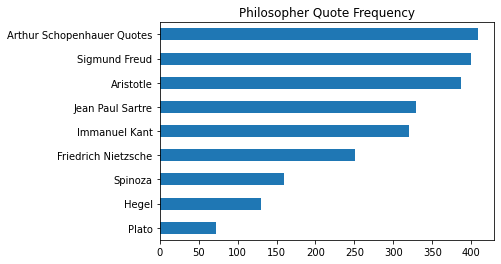

In [123]:
df['label'].value_counts(ascending=True).plot.barh()
plt.title('Philosopher Quote Frequency')
plt.show()

In [124]:
df['label'].value_counts()

Arthur Schopenhauer Quotes    409
Sigmund Freud                 400
Aristotle                     387
Jean Paul Sartre              329
Immanuel Kant                 320
Friedrich Nietzsche           251
Spinoza                       160
Hegel                         130
Plato                          72
Name: label, dtype: int64

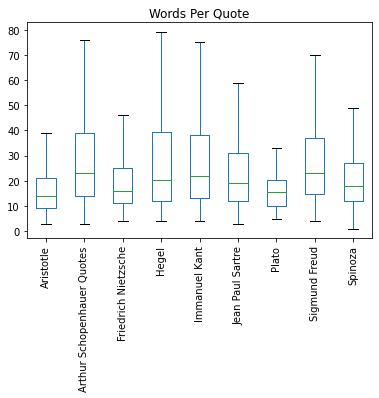

In [125]:
df['Words Per Quote'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Quote', rot = 90, by='label', grid=False, showfliers=False)
plt.suptitle('')
plt.xlabel('')
plt.show()

In [126]:
df.groupby("label")["Words Per Quote"].mean()

label
Aristotle                     18.700258
Arthur Schopenhauer Quotes    29.249389
Friedrich Nietzsche           21.721116
Hegel                         29.392308
Immanuel Kant                 28.596875
Jean Paul Sartre              24.878419
Plato                         19.902778
Sigmund Freud                 28.042500
Spinoza                       22.787500
Name: Words Per Quote, dtype: float64

In [127]:
df.drop(labels = 'Words Per Quote', axis=1, inplace=True)

In [128]:
label_code = {}
i = 0

for name in df['label'].unique():
    label_code[name] = i
    i += 1
    
label_code

{'Jean Paul Sartre': 0,
 'Aristotle': 1,
 'Immanuel Kant': 2,
 'Plato': 3,
 'Hegel': 4,
 'Spinoza': 5,
 'Arthur Schopenhauer Quotes': 6,
 'Friedrich Nietzsche': 7,
 'Sigmund Freud': 8}

In [129]:
df.replace(to_replace=label_code, inplace=True)

In [130]:
len(df['label'].unique())

9

In [131]:
df

,text,label
0,We are our choices.,0
1,What is life but an unpleasant interruption to a peaceful nonexistence.,0
2,"Every word has consequences. Every silence, too.",0
3,the worst part about being lied to is knowing you werent worth the truth,0
4,Only the guy who isn't rowing has time to rock the boat.,0
...,...,...
2453,"Lead us, Heavenly Father, lead us O'er the world's tempestuous sea; Guard us, guide us, keep us, feed us, For we have no help but Thee.",8
2454,"The liberty of the individual is no gift of civilization. It was greatest before there was any civilization, though then, it is true, it had for the most part no value, since the individual was scarcely in a position to defend it. The development of civilization imposes restrictions on it, and justice demands that no one shall escape those restrictions.",8
2455,"Towards the outside, at any rate, the ego seems to maintain clear and sharp lines of demarcation. There is only one state -- admittedly an unusual state, but not one that can be stigmatized as pathological -- in which it does not do this. At the height of being in love the boundary between ego and object threatens to melt away. Against all the evidence of his senses, a man who is in love declares that ""I"" and ""you"" are one, and is prepared to behave as if it were a fact.",8
2456,Civilization runs a greater risk if we maintain our present attitude to religion than if we give it up.,8


In [132]:
ds = Dataset.from_pandas(df)

In [133]:
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 2458
})

In [134]:
shuffle_ds = ds.shuffle(seed=42)

In [135]:
final_ds = ds.train_test_split(0.1)

In [136]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2212
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 246
    })
})

In [137]:
model_cp = 'distilbert-base-uncased'

In [138]:
tokenizer = AutoTokenizer.from_pretrained(model_cp)

In [82]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [139]:
encoded_ds = final_ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [175]:
encoded_ds['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [141]:
model = AutoModelForSequenceClassification.from_pretrained(model_cp, num_labels = 9)

In [142]:
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(preds, labels)
    f1 = f1_score(preds, labels, average='weighted')
    return {"accuracy" : acc , "f1" : f1}

In [143]:
batch_size = 64
logging_steps = len(encoded_ds['train']) // batch_size
model_name = f'{model_cp}-finetuned-phil-quotes'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

In [144]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                train_dataset=encoded_ds['train'],
                eval_dataset=encoded_ds['test'],
                tokenizer=tokenizer)

In [145]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.113100,2.044504,0.304878,0.361436
2,1.989900,2.006916,0.313008,0.358516


TrainOutput(global_step=70, training_loss=2.0480199950081963, metrics={'train_runtime': 55.1274, 'train_samples_per_second': 80.251, 'train_steps_per_second': 1.27, 'total_flos': 165987880415280.0, 'train_loss': 2.0480199950081963, 'epoch': 2.0})

In [198]:
data2 = []

for name in os.listdir(path):
    with open((path/name), encoding='cp1252', newline='') as f:
        lines = f.readlines()
        lines = ''.join(lines).replace('\r\n', ' ').replace("\'" , "")
        data2.append([lines, name.replace('.txt', '').replace('-', ' ')])

In [199]:
len_words = []
words = []
for i in range(len(data2)):
    len_words.append([len(data2[i][0].split()), data2[i][1]])
    words.append([data2[i][0].split(), data2[i][1]])

In [200]:
train_words = []
val_words = []

for i in range(len(words)):
    train_words.append([words[i][0][690:], words[i][1]])
    val_words.append([words[i][0][:690],words[i][1]])

In [201]:
avg = int((np.array(len_words)[:,0].astype(int).mean()-1).round())
avg-690, 690

(6210, 690)

In [206]:
for i in range(len(words)):
    if len(train_words[i][0]) > avg-690:
        print(i, 'Correct length')
    else:
        train_words[i][0].extend(train_words[i][0]) 
    print(len(train_words[i][0]), len(val_words[i][0]))

0 Correct length
7495 690
1 Correct length
6547 690
2 Correct length
8461 690
3 Correct length
11888 690
4 Correct length
6262 690
5 Correct length
11824 690
6 Correct length
11273 690
7 Correct length
9524 690
8 Correct length
10527 690


In [207]:
for i in range(len(train_words)):
    train_words[i][0] = train_words[i][0][0:(avg-690)]

In [208]:
for i in range(len(train_words)):
    print(len(train_words[i][0]), len(val_words[i][0]))

6210 690
6210 690
6210 690
6210 690
6210 690
6210 690
6210 690
6210 690
6210 690


In [209]:
train_words[0][0] = ' '.join(train_words[0][0])
train_words[1][0] = ' '.join(train_words[1][0])
train_words[2][0] = ' '.join(train_words[2][0])
train_words[3][0] = ' '.join(train_words[3][0])
train_words[4][0] = ' '.join(train_words[4][0])
train_words[5][0] = ' '.join(train_words[5][0])
train_words[6][0] = ' '.join(train_words[6][0])
train_words[7][0] = ' '.join(train_words[7][0])
train_words[8][0] = ' '.join(train_words[8][0])

In [210]:
val_words[0][0] = ' '.join(val_words[0][0])
val_words[1][0] = ' '.join(val_words[1][0])
val_words[2][0] = ' '.join(val_words[2][0])
val_words[3][0] = ' '.join(val_words[3][0])
val_words[4][0] = ' '.join(val_words[4][0])
val_words[5][0] = ' '.join(val_words[5][0])
val_words[6][0] = ' '.join(val_words[6][0])
val_words[7][0] = ' '.join(val_words[7][0])
val_words[8][0] = ' '.join(val_words[8][0])

In [211]:
def splitter(n, s):
    pieces = s.split()
    return (" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n))

In [212]:
train_final = []

for i in range(len(train_words)):
    for piece in splitter(30, train_words[0][0]):
        train_final.append([piece, train_words[i][1]])

In [213]:
train_final[0]

['choices. We do not judge the people we love. Man is not the sum of what he has already, but rather the sum of what he does not yet have,',
 'Jean Paul Sartre']

In [214]:
valid_final = []

for i in range(len(val_words)):
    for piece in splitter(30, val_words[0][0]):
        valid_final.append([piece, val_words[i][1]])

In [215]:
df_train = pd.DataFrame(train_final).rename(columns={0:'text',1:'label'})
df_valid = pd.DataFrame(valid_final).rename(columns={0:'text',1:'label'})

In [216]:
df_train.replace(to_replace=label_code, inplace=True)
df_valid.replace(to_replace=label_code, inplace=True)

In [217]:
ds_train = Dataset.from_pandas(df_train)
ds_valid = Dataset.from_pandas(df_valid)

In [218]:
shuffled_ds_train = ds_train.shuffle(seed=42)
shuffled_ds_valid = ds_valid.shuffle(seed=42)

In [219]:
shuffled_ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 1863
})

In [220]:
shuffled_ds_valid

Dataset({
    features: ['text', 'label'],
    num_rows: 207
})

In [221]:
train_valid_dataset = DatasetDict({
    'train': shuffled_ds_train,
    'valid': shuffled_ds_valid})

In [222]:
final = train_valid_dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [223]:
final['train']['text'][0]

'passion. He will never agree that a sweeping passion is a ravaging torrent which fatally leads a man to certain acts and is therefore an excuse. He thinks that man'

In [224]:
final['train']['label'][0]

0

In [225]:
batch_size = 64
logging_steps = len(final['train']) // batch_size
model_name = f'{model_cp}-finetuned-phil-quotes-2'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

In [226]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                train_dataset=final['train'],
                eval_dataset=final['valid'],
                tokenizer=tokenizer)

In [227]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.213100,2.197844,0.111111,0.167001
2,2.201900,2.197696,0.111111,0.148789


TrainOutput(global_step=60, training_loss=2.207453234990438, metrics={'train_runtime': 14.5688, 'train_samples_per_second': 255.751, 'train_steps_per_second': 4.118, 'total_flos': 48206556901800.0, 'train_loss': 2.207453234990438, 'epoch': 2.0})